<a href="https://colab.research.google.com/github/MadeehaTassadaq/Phi-data-agent/blob/main/langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade langchain langchain_community langgraph langchain_groq langchain_ollama

In [ ]:
from google.colab import userdata
groq_api_key=userdata.get('groq_api_Key')

In [ ]:
from typing import List,Dict
from langgraph.graph import START,END,StateGraph
from langchain_groq import ChatGroq
from langchain_ollama.llms import OllamaLLM

In [ ]:
# step 1 define state
class State(Dict):
  messages: list[Dict[str,str]]

In [ ]:
# step 2 initialize State graph
state_graph = StateGraph(State)

In [ ]:
# step 3 initialize llm
llm=ChatGroq(model="deepseek-r1-distill-llama-70b",api_key=groq_api_key)
llm_ollama=OllamaLLM(model="deepseek-r1:1.5b")

In [ ]:
# Define chatbot function
def chatbot(state: State):
    response = llm_ollama.invoke(state["messages"])
    state["messages"].append({"role": "assistant", "content": response})  # Treat response as a string
    return {"messages": state["messages"]}

In [ ]:
# Add nodes and edges
state_graph.add_node("chatbot",chatbot)
state_graph.add_edge(START,"chatbot")
state_graph.add_edge("chatbot",END)

In [ ]:
# Compile the graph
graph = state_graph.compile()

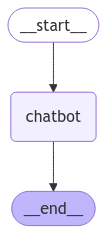

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Stream updates
def stream_graph_updates(user_input: str):
    state = {"messages": [{"role": "user", "content": user_input}]}
    for event in graph.stream(state):
        for value in event.values():
            print("Assistant:", value["messages"][-1]["content"])

In [ ]:
# Run chatbot in a loop
if __name__ == "__main__":
    while True:
        try:
            user_input = input("User: ")
            if user_input.lower() in ["quit", "exit", "q"]:
                print("Goodbye!")
                break

            stream_graph_updates(user_input)
        except Exception as e:
            print(f"An error occurred: {e}")
            break

User: hi
An error occurred: [Errno 111] Connection refused


In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

In [ ]:
!pip install arxiv wikipedia

In [ ]:
# working with tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
# ## Arxiv And Wikipedia tools
wiki_tools=WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
arxiv_tools=ArxivQueryRun(api_wrapper=ArxivAPIWrapper())

In [ ]:
LANGSMITH_TRACING_V2="true"
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY="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"
LANGSMITH_PROJECT="langgraph"

In [ ]:
arxiv_tools.run("What is attention you need")

"Published: 2023-11-20\nTitle: System 2 Attention (is something you might need too)\nAuthors: Jason Weston, Sainbayar Sukhbaatar\nSummary: Soft attention in Transformer-based Large Language Models (LLMs) is\nsusceptible to incorporating irrelevant information from the context into its\nlatent representations, which adversely affects next token generations. To help\nrectify these issues, we introduce System 2 Attention (S2A), which leverages\nthe ability of LLMs to reason in natural language and follow instructions in\norder to decide what to attend to. S2A regenerates the input context to only\ninclude the relevant portions, before attending to the regenerated context to\nelicit the final response. In experiments, S2A outperforms standard\nattention-based LLMs on three tasks containing opinion or irrelevant\ninformation, QA, math word problems and longform generation, where S2A\nincreases factuality and objectivity, and decreases sycophancy.\n\nPublished: 2019-12-30\nTitle: Is Attentio

In [ ]:
wiki_tools.run("who is nawaz sharif")

"Page: Nawaz Sharif\nSummary: Mian Muhammad Nawaz Sharif (born 25 December 1949) is a Pakistani politician and businessman who served as the 12th prime minister of Pakistan for three non-consecutive terms, first serving from 1990 to 1993, then from 1997 to 1999 and later from 2013 to 2017. He is the longest-serving prime minister of Pakistan, having served a total of more than 9 years across three tenures. Each term has ended in his ousting.\nBorn into the upper-middle-class Sharif family in Lahore, Nawaz is the son of Muhammad Sharif, the founder of Ittefaq and Sharif groups. Nawaz studied business at Government College and law at the University of Punjab. Nawaz entered into politics in 1981, when he was appointed by President Zia as the minister of finance for the province of Punjab. Backed by a loose coalition of conservatives, Nawaz was elected as the chief minister of Punjab in 1985 and re-elected after the end of martial law in 1988. \nIn 1990, Nawaz led the conservative Islamic 

In [ ]:
arxiv_tools.run('Who is Sharukh Khan')

"Published: 2020-08-11\nTitle: Planimation\nAuthors: Gang Chen, Yi Ding, Hugo Edwards, Chong Hin Chau, Sai Hou, Grace Johnson, Mohammed Sharukh Syed, Haoyuan Tang, Yue Wu, Ye Yan, Gil Tidhar, Nir Lipovetzky\nSummary: Planimation is a modular and extensible open source framework to visualise\nsequential solutions of planning problems specified in PDDL. We introduce a\npreliminary declarative PDDL-like animation profile specification, expressive\nenough to synthesise animations of arbitrary initial states and goals of a\nbenchmark with just a single profile.\n\nPublished: 2024-06-14\nTitle: The inadequacy of the geometric features of MA islands in relating bainite microstructures to composition and processing conditions\nAuthors: Vinod Kumar, Sharukh Hussain, Priyanka S, P G Kubendran Amos\nSummary: Achieving desired properties in bainite steels with MA islands demands\nunderstanding the affect of processing conditions and composition on their size\nand morphology. Generally, this unders

In [ ]:
tools=[arxiv_tools,wiki_tools]

In [ ]:
# langgraph application
class State(Dict):
  messages:list[Dict[str,str]]

In [ ]:
graph_builder=StateGraph(State)

In [ ]:
llm_with_tools=llm.bind_tools(tools=tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x79d399453350>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x79d39979c0d0>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from scientific articles on arxiv.org. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies,

In [ ]:
def chatbot(state:State):
  response=llm_with_tools.invoke(state["messages"])
  state["messages"].append({"role":"assistant","content":response})
  return {"messages":state["messages"]}

In [ ]:
from langgraph.prebuilt import tools_condition,ToolNode

In [ ]:
graph_builder.add_node("chatbot",chatbot)
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)

In [ ]:
graph_builder.add_conditional_edges("chatbot",tools_condition)

In [ ]:
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")

In [ ]:
graph=graph_builder.compile()

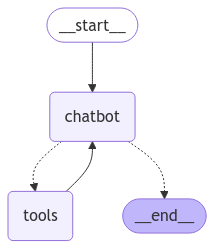

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1]["content"])


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:

        print("User: " , user_input)
        break

User: what is attention all you need
Assistant: content='' additional_kwargs={'tool_calls': [{'id': 'call_a46y', 'function': {'arguments': '{"query":"attention is all you need"}', 'name': 'arxiv'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 105, 'prompt_tokens': 254, 'total_tokens': 359, 'completion_time': 0.381818182, 'prompt_time': 0.012654999, 'queue_time': 0.081992212, 'total_time': 0.394473181}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_af2982c95d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-f3283e10-9989-4c54-8ca8-86e071cb5493-0' tool_calls=[{'name': 'arxiv', 'args': {'query': 'attention is all you need'}, 'id': 'call_a46y', 'type': 'tool_call'}] usage_metadata={'input_tokens': 254, 'output_tokens': 105, 'total_tokens': 359}
User: what is transformers
Assistant: content='' additional_kwargs={'tool_calls': [{'id': 'call_zmte', 'function': {'arguments': '{"query":"transformers"}', 'name': 'wikipedia'}, 